# 提取 gamma 单谱上的峰面积

In [1]:
TFile *ipf = new TFile("../MergedData/decay47_128.root");
TTree *tree = (TTree*)ipf->Get("tree");
TCanvas *c1 = new TCanvas;

In [2]:
.L peaks.C

### 3个beta半衰期内的单谱

In [3]:
int halflife = 60;  // in ms

In [4]:
%jsroot on
//tree->Draw("ae>>h(3500,0,3500)",Form("decaytime<%d && decaytime>10 && 366-at<300 && 366-at>-300",3*halflife));
tree->Draw("ae>>h(3500,0,3500)",Form("decaytime<%d && decaytime>10",3*halflife));
peaks("h");
c1->Draw();

### 拟合函数定义

In [5]:
vector<double> e;            //e[0]为目标峰，其他为周围峰
double k,b;                  //线性本底参数
double fit_left,fit_right;   //联合拟合范围
double area_left,area_right; //峰面积计算范围

In [6]:
void area()
{
    c1->Clear();
    h->GetXaxis()->SetRangeUser(0,3500);        //返回全区间，在多次进行拟合时，必须要有这个操作，否则指定的拟合区间将存在问题

    //设置拟合函数：线性本底 + npeaks个高斯函数
    int npeaks = e.size();
    TString sf = "pol1(0)";
    for (int i=0; i<npeaks; i++)
        sf += Form("+gaus(%d)",3*i+2);
    TF1* f = new TF1("f", sf, fit_left, fit_right);
    f->FixParameter(0, b);                         //手动设置线性本底
    f->FixParameter(1, k);
    for (int i=0; i<npeaks; i++){
        f->SetParameter(3*i+2, 100);               //峰高
        f->SetParLimits(3*i+2, 1, 1e10);
        f->SetParameter(3*i+3, e[i]);              //峰中心
        f->SetParLimits(3*i+3, e[i]-1, e[i]+1);
        f->SetParameter(3*i+4, 1);                 //峰宽sigma
        f->SetParLimits(3*i+4, 0.5, 2);
    }
    
    TFitResultPtr fh = h->Fit(f, "QRS");
    f->SetLineColor(kRed);
    f->Draw("same");

    //单独提出线性本底
    TF1 *f1 = new TF1("f1", "pol1", 0, 3500);
    f1->SetParameter(0, b);
    f1->SetParameter(1, k);
    f1->SetLineColor(kBlue);
    f1->Draw("same");
    
    //提出联合拟合结果中的各个高斯峰
    TF1 *fg[npeaks];
    for (int i=0; i<npeaks; i++){
        fg[i] = new TF1(Form("fg%d",i), "gaus");
        fg[i]->SetParameter(0, f->GetParameter(3*i+2));
        fg[i]->SetParameter(1, f->GetParameter(3*i+3));
        fg[i]->SetParameter(2, f->GetParameter(3*i+4));
    }

    //计算峰面积
    int bin1 = h->FindBin(area_left);
    int bin2 = h->FindBin(area_right);
    double nall = h->Integral(bin1, bin2);                     //包含本底的总计数
    
    double x1 = h->GetBinLowEdge(bin1);                        //积分下界
    double x2 = h->GetBinLowEdge(bin2)+h->GetBinWidth(bin2);   //积分上界，注意使用了与TH1完全相等的积分范围
    double nbg = f1->Integral(x1, x2)/h->GetBinWidth(bin2);    //线性本底贡献
    for (int i=1; i<npeaks; i++)
        nbg += fg[i]->Integral(x1, x2)/h->GetBinWidth(bin2);   //其他高斯峰贡献；fg[0]是目标峰，不算进本底中

    //输出结果
    for (int i=0; i<npeaks; i++)
        cout<<i<<" peak="<<fg[i]->GetParameter(1)<<"("<<f->GetParError(3*i+3)<<")"<<" height="<<fg[i]->GetParameter(0)
        <<" sigma="<<fg[i]->GetParameter(2)<<" contribution="<<fg[i]->Integral(x1, x2)/h->GetBinWidth(bin2)<<'\n';
    cout<<"chi2/ndf="<<fh->Chi2()/fh->Ndf()<<" count="<<nall-nbg<<" delta_count="<<sqrt(nall+nbg)<<endl;
}

## 逐峰拟合提取面积

In [7]:
%jsroot off

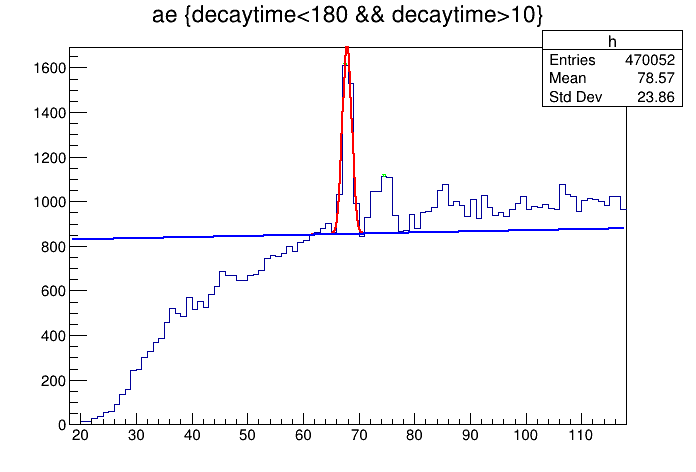

0 peak=67.9293(0.0394389) height=871.046 sigma=0.805767 contribution=1735.71
chi2/ndf=12.4502 count=1747 delta_count=92.6229


In [8]:
e = vector<double> {68};
k = 0.5; b = 820;                      //线性本底参数
fit_left = e[0]-10; fit_right = e[0]+10;       //联合拟合范围
area_left = e[0]-2; area_right = e[0]+1;     //峰面积计算范围
area();
h->GetXaxis()->SetRangeUser(e[0]-50,e[0]+50); //设置显示区间
c1->Draw();

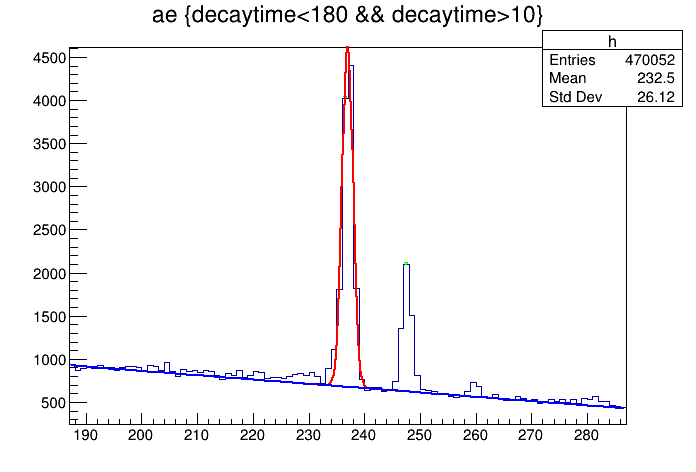

0 peak=237.013(0.0130456) height=4001.62 sigma=0.968566 contribution=9696.3
chi2/ndf=37.0477 count=9901 delta_count=134.168


In [9]:
e = vector<double> {237};
k = -5; b = 1860;                      //线性本底参数
fit_left = e[0]-10; fit_right = e[0]+10;       //联合拟合范围
area_left = e[0]-3; area_right = e[0]+2;     //峰面积计算范围
area();
h->GetXaxis()->SetRangeUser(e[0]-50,e[0]+50); //设置显示区间
c1->Draw();

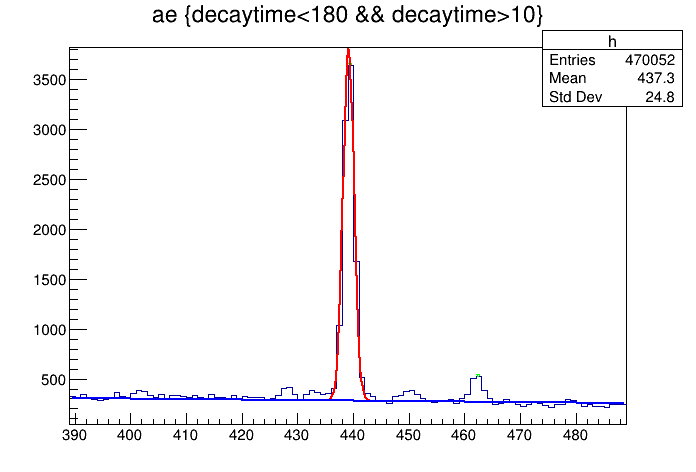

0 peak=439.187(0.0124238) height=3531.04 sigma=0.979741 contribution=8542.9
chi2/ndf=8.02592 count=8564.75 delta_count=106.617


In [10]:
e = vector<double> {439};
k = -0.5; b = 500;                      //线性本底参数
fit_left = e[0]-10; fit_right = e[0]+10;       //联合拟合范围
area_left = e[0]-2; area_right = e[0]+2;     //峰面积计算范围
area();
h->GetXaxis()->SetRangeUser(e[0]-50,e[0]+50); //设置显示区间
c1->Draw();

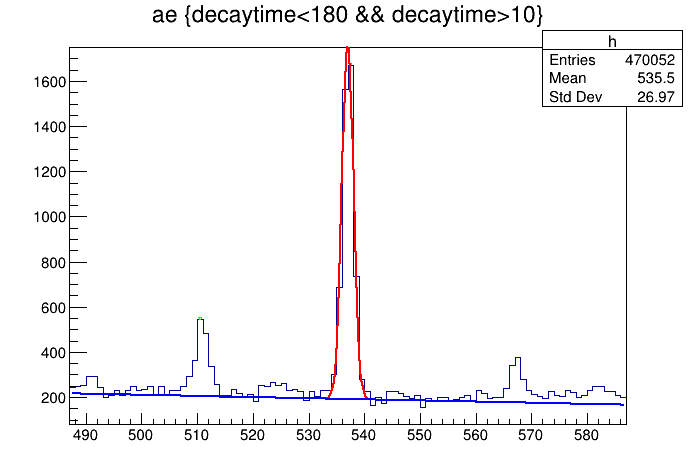

0 peak=537.034(0.0199259) height=1591.64 sigma=1.02284 contribution=4080.39
chi2/ndf=3.65938 count=4167 delta_count=85.0353


In [11]:
e = vector<double> {537};
k = -0.5; b = 460;                      //线性本底参数
fit_left = e[0]-10; fit_right = e[0]+10;       //联合拟合范围
area_left = e[0]-4; area_right = e[0]+3;     //峰面积计算范围
area();
h->GetXaxis()->SetRangeUser(e[0]-50,e[0]+50); //设置显示区间
c1->Draw();

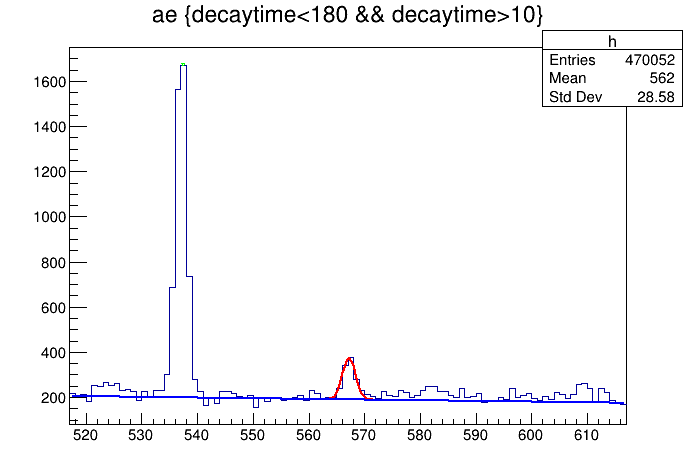

0 peak=567.274(0.106691) height=181.633 sigma=1.16758 contribution=529.862
chi2/ndf=2.1797 count=551.75 delta_count=56.6414


In [32]:
e = vector<double> {567};
k = -0.3; b = 360;                      //线性本底参数
fit_left = e[0]-10; fit_right = e[0]+10;       //联合拟合范围
area_left = e[0]-3; area_right = e[0]+3;     //峰面积计算范围
area();
h->GetXaxis()->SetRangeUser(e[0]-50,e[0]+50); //设置显示区间
c1->Draw();

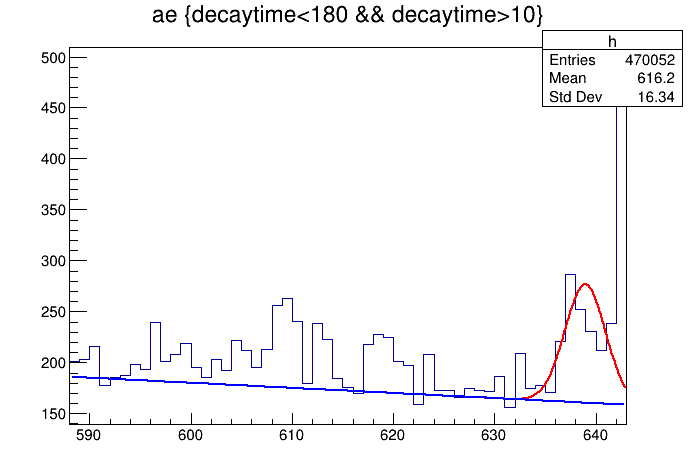

0 peak=639(0.023946) height=116.139 sigma=2 contribution=450.964
chi2/ndf=741.169 count=399.25 delta_count=44.7968


In [55]:
e = vector<double> {638};
k = -0.5; b = 480;                      //线性本底参数
fit_left = e[0]-10; fit_right = e[0]+10;       //联合拟合范围
area_left = e[0]-2; area_right = e[0]+2;     //峰面积计算范围
area();
h->GetXaxis()->SetRangeUser(e[0]-50,e[0]+5); //设置显示区间
c1->Draw();

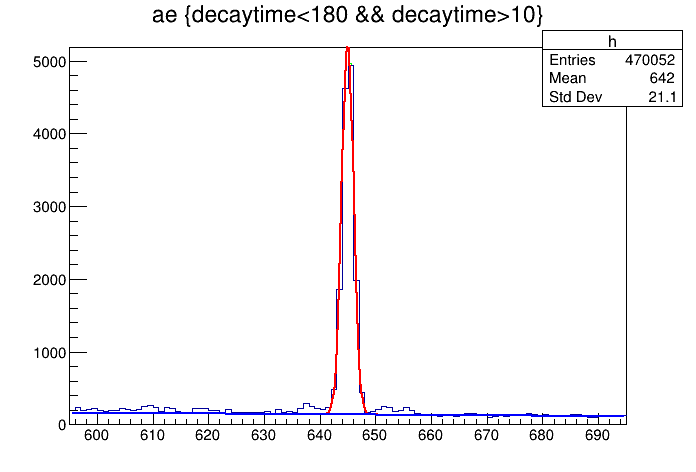

0 peak=645.023(0.00978699) height=5145.15 sigma=1.05158 contribution=13503.3
chi2/ndf=26.0853 count=13540 delta_count=123.248


In [13]:
e = vector<double> {645};
k = -0.5; b = 460;                      //线性本底参数
fit_left = e[0]-10; fit_right = e[0]+10;       //联合拟合范围
area_left = e[0]-3; area_right = e[0]+2;     //峰面积计算范围
area();
h->GetXaxis()->SetRangeUser(e[0]-50,e[0]+50); //设置显示区间
c1->Draw();

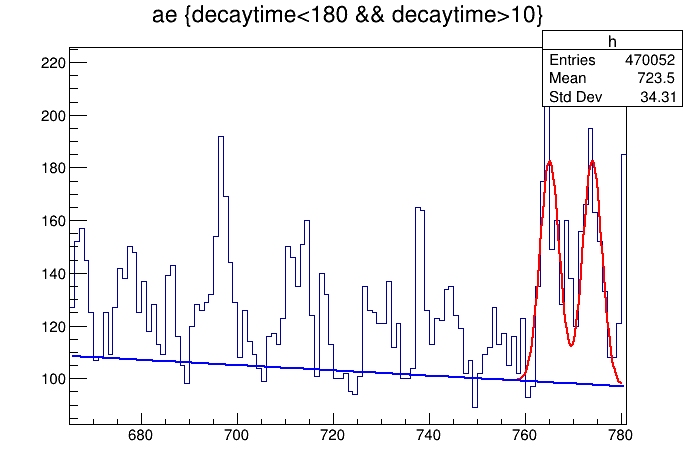

0 peak=765.111(0.224016) height=83.9701 sigma=2 contribution=364.467
1 peak=774(0.0493131) height=85.1016 sigma=2 contribution=0.575915
chi2/ndf=2.98037 count=374.424 delta_count=39.4661


In [14]:
e = vector<double> {765,775};
k = -0.1; b = 175;                      //线性本底参数
fit_left = e[0]-10; fit_right = e[0]+15;       //联合拟合范围
area_left = e[0]-3; area_right = e[0]+2;     //峰面积计算范围
area();
h->GetXaxis()->SetRangeUser(e[0]-100,e[0]+16); //设置显示区间
c1->Draw();

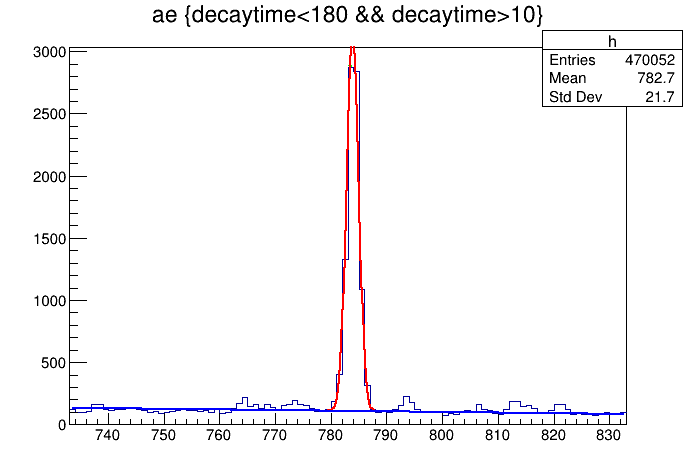

0 peak=783.921(0.0133063) height=2997.41 sigma=1.09469 contribution=8173.27
chi2/ndf=7.07823 count=8206 delta_count=97.4782


In [15]:
e = vector<double> {783};
k = -0.5; b = 500;                      //线性本底参数
fit_left = e[0]-10; fit_right = e[0]+10;       //联合拟合范围
area_left = e[0]-2; area_right = e[0]+3;     //峰面积计算范围
area();
h->GetXaxis()->SetRangeUser(e[0]-50,e[0]+50); //设置显示区间
c1->Draw();

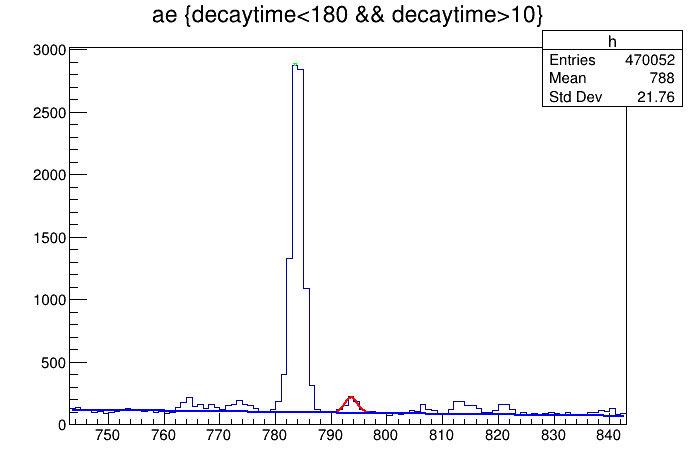

0 peak=793.666(0.114486) height=121.708 sigma=1.15272 contribution=347.347
chi2/ndf=376.249 count=357 delta_count=38.3797


In [34]:
e = vector<double> {793};
k = -0.5; b = 490;                      //线性本底参数
fit_left = e[0]-10; fit_right = e[0]+10;       //联合拟合范围
area_left = e[0]-2; area_right = e[0]+3;     //峰面积计算范围
area();
h->GetXaxis()->SetRangeUser(e[0]-50,e[0]+50); //设置显示区间
c1->Draw();

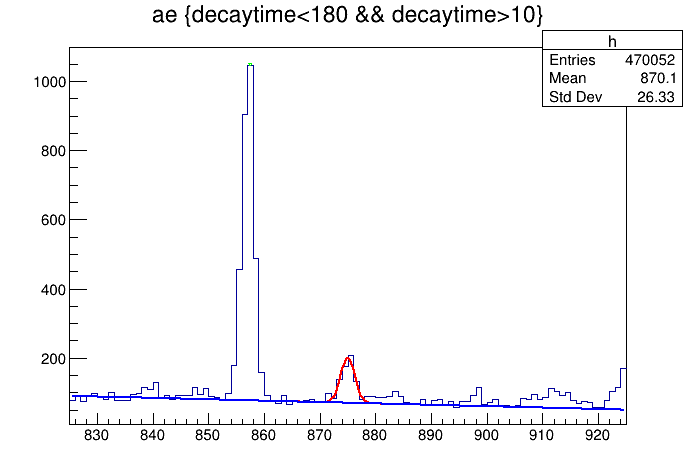

0 peak=875.063(0.106341) height=129.707 sigma=1.26577 contribution=364.4
chi2/ndf=3.01137 count=374 delta_count=30.5614


In [16]:
e = vector<double> {875};
k = -0.4; b = 420;                      //线性本底参数
fit_left = e[0]-10; fit_right = e[0]+10;       //联合拟合范围
area_left = e[0]-2; area_right = e[0]+1;     //峰面积计算范围
area();
h->GetXaxis()->SetRangeUser(e[0]-50,e[0]+50); //设置显示区间
c1->Draw();

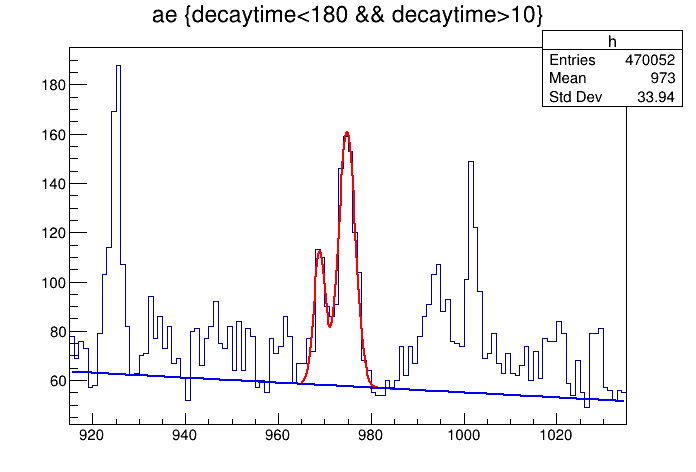

0 peak=974.9(0.152212) height=103.245 sigma=1.80664 contribution=436.771
1 peak=969(0.217569) height=53.8067 sigma=1.2388 contribution=1.29057
chi2/ndf=0.683606 count=437.559 delta_count=35.2766


In [17]:
e = vector<double> {975,968};
k = -0.1; b = 155;                      //线性本底参数
fit_left = e[0]-10; fit_right = e[0]+10;       //联合拟合范围
area_left = e[0]-3; area_right = e[0]+3;     //峰面积计算范围
area();
h->GetXaxis()->SetRangeUser(e[0]-60,e[0]+60); //设置显示区间
c1->Draw();

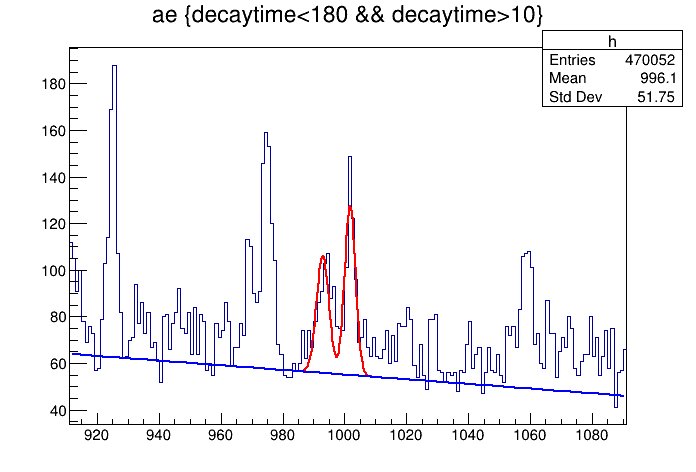

0 peak=1001.84(0.174207) height=72.6551 sigma=1.75376 contribution=303.371
1 peak=993(0.0608346) height=50.473 sigma=2 contribution=1.57126
chi2/ndf=2.43013 count=300.479 delta_count=32.7341


In [43]:
e = vector<double> {1001,992};
k = -0.1; b = 155;                      //线性本底参数
fit_left = e[0]-15; fit_right = e[0]+10;       //联合拟合范围
area_left = e[0]-3; area_right = e[0]+3;     //峰面积计算范围
area();
h->GetXaxis()->SetRangeUser(e[0]-90,e[0]+90); //设置显示区间
c1->Draw();

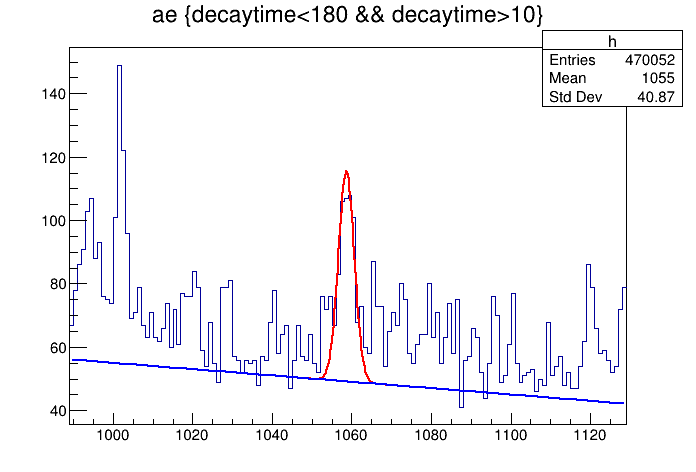

0 peak=1058.73(0.237464) height=66.211 sigma=2 contribution=286.379
chi2/ndf=3.73066 count=278.4 delta_count=29.4551


In [18]:
e = vector<double> {1059};
k = -0.1; b = 155;                      //线性本底参数
fit_left = e[0]-10; fit_right = e[0]+10;       //联合拟合范围
area_left = e[0]-3; area_right = e[0]+2;     //峰面积计算范围
area();
h->GetXaxis()->SetRangeUser(e[0]-70,e[0]+70); //设置显示区间
c1->Draw();

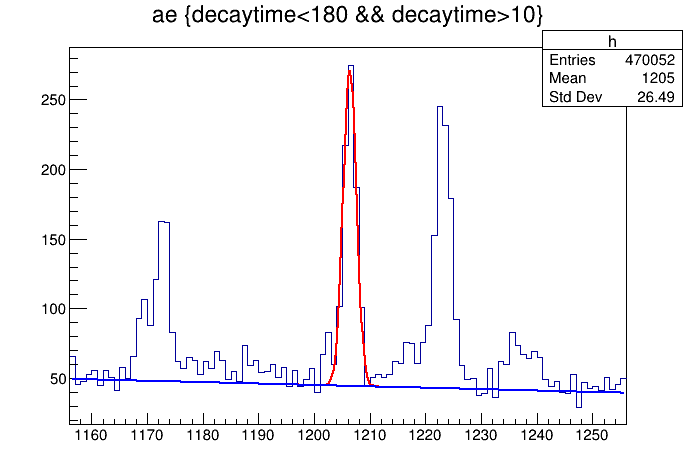

0 peak=1206.41(0.0616443) height=227.12 sigma=1.19403 contribution=668.145
chi2/ndf=2.82308 count=675.6 delta_count=34.762


In [19]:
e = vector<double> {1206};
k = -0.1; b = 165;                      //线性本底参数
fit_left = e[0]-10; fit_right = e[0]+10;       //联合拟合范围
area_left = e[0]-3; area_right = e[0]+2;     //峰面积计算范围
area();
h->GetXaxis()->SetRangeUser(e[0]-50,e[0]+50); //设置显示区间
c1->Draw();

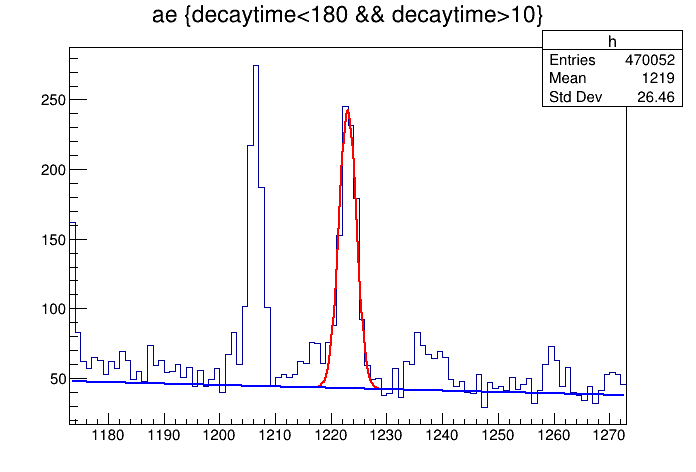

0 peak=1223.04(0.0761997) height=199.665 sigma=1.55852 contribution=737.636
chi2/ndf=3.39325 count=732.8 delta_count=35.2874


In [20]:
e = vector<double> {1223};
k = -0.1; b = 165;                      //线性本底参数
fit_left = e[0]-10; fit_right = e[0]+10;       //联合拟合范围
area_left = e[0]-3; area_right = e[0]+2;     //峰面积计算范围
area();
h->GetXaxis()->SetRangeUser(e[0]-50,e[0]+50); //设置显示区间
c1->Draw();

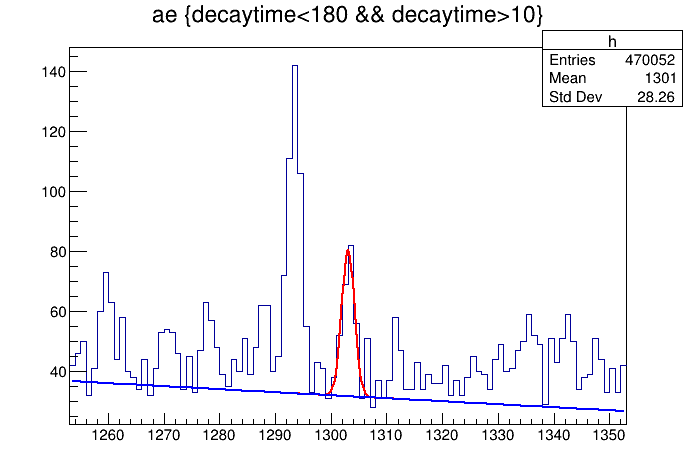

0 peak=1303.11(0.1773) height=48.701 sigma=1.14393 contribution=132.305
chi2/ndf=10.5149 count=138.25 delta_count=21.3483


In [21]:
e = vector<double> {1303};
k = -0.1; b = 162;                      //线性本底参数
fit_left = e[0]-10; fit_right = e[0]+10;       //联合拟合范围
area_left = e[0]-3; area_right = e[0]+1;     //峰面积计算范围
area();
h->GetXaxis()->SetRangeUser(e[0]-50,e[0]+50); //设置显示区间
c1->Draw();

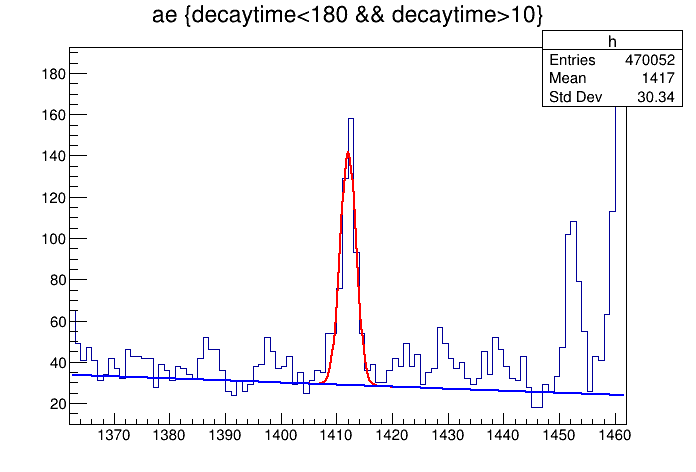

0 peak=1412.13(0.101405) height=112.832 sigma=1.42796 contribution=389.14
chi2/ndf=1.68221 count=391.2 delta_count=27.1441


In [22]:
e = vector<double> {1412};
k = -0.1; b = 170;                      //线性本底参数
fit_left = e[0]-10; fit_right = e[0]+10;       //联合拟合范围
area_left = e[0]-3; area_right = e[0]+2;     //峰面积计算范围
area();
h->GetXaxis()->SetRangeUser(e[0]-50,e[0]+50); //设置显示区间
c1->Draw();

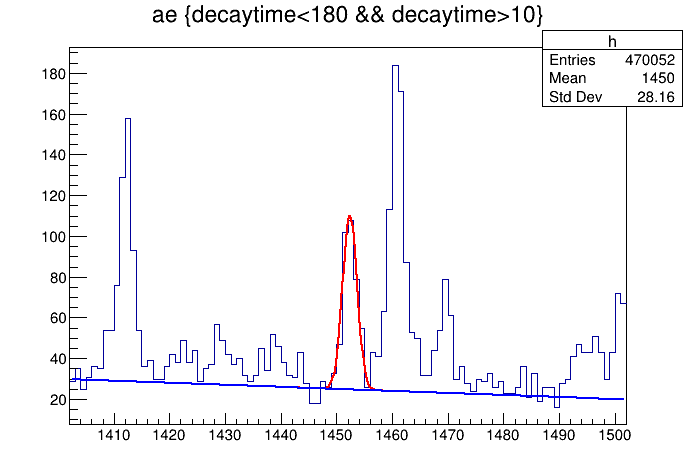

0 peak=1452.42(0.11471) height=85.3483 sigma=1.29443 contribution=269.356
chi2/ndf=23.1036 count=275.2 delta_count=23.9332


In [23]:
e = vector<double> {1452};
k = -0.1; b = 170;                      //线性本底参数
fit_left = e[0]-10; fit_right = e[0]+10;       //联合拟合范围
area_left = e[0]-3; area_right = e[0]+2;     //峰面积计算范围
area();
h->GetXaxis()->SetRangeUser(e[0]-50,e[0]+50); //设置显示区间
c1->Draw();

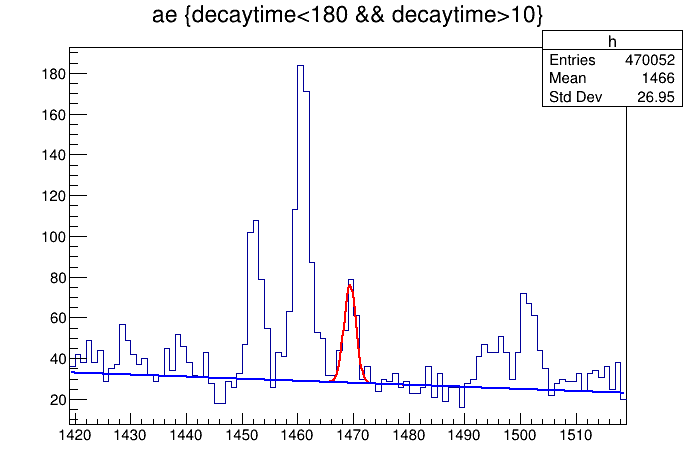

0 peak=1469.45(0.18175) height=47.7446 sigma=1.074 contribution=127.311
chi2/ndf=22.217 count=131.4 delta_count=21.6472


In [24]:
e = vector<double> {1469};
k = -0.1; b = 175;                      //线性本底参数
fit_left = e[0]-10; fit_right = e[0]+10;       //联合拟合范围
area_left = e[0]-3; area_right = e[0]+2;     //峰面积计算范围
area();
h->GetXaxis()->SetRangeUser(e[0]-50,e[0]+50); //设置显示区间
c1->Draw();

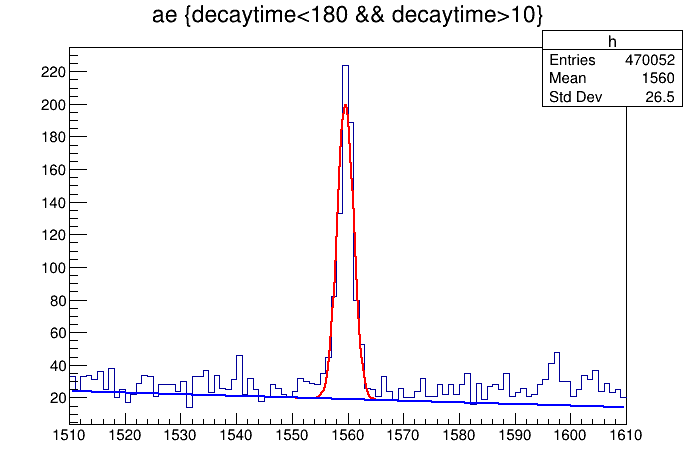

0 peak=1559.62(0.0695598) height=180.788 sigma=1.47768 contribution=643.161
chi2/ndf=2.6352 count=654.35 delta_count=30.3257


In [25]:
e = vector<double> {1560};
k = -0.1; b = 175;                      //线性本底参数
fit_left = e[0]-10; fit_right = e[0]+10;       //联合拟合范围
area_left = e[0]-3; area_right = e[0]+3;     //峰面积计算范围
area();
h->GetXaxis()->SetRangeUser(e[0]-50,e[0]+50); //设置显示区间
c1->Draw();

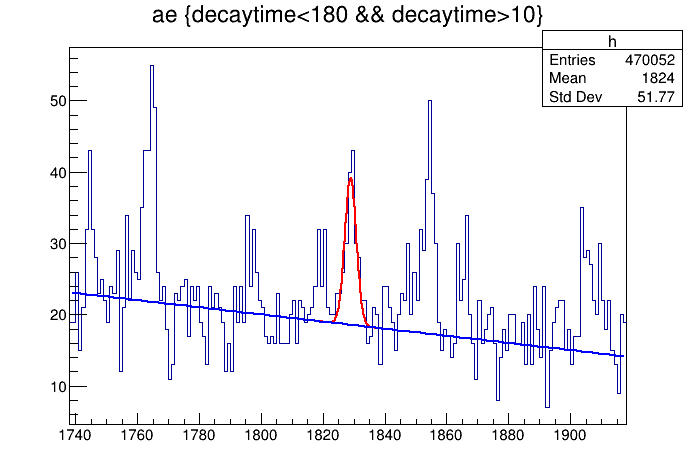

0 peak=1829(1.41667) height=20.5669 sigma=1.85874 contribution=80.8125
chi2/ndf=0.887703 count=80.4 delta_count=17.4241


In [50]:
e = vector<double> {1828};
k = -0.05; b = 110;                      //线性本底参数
fit_left = e[0]-10; fit_right = e[0]+10;       //联合拟合范围
area_left = e[0]-3; area_right = e[0]+2;     //峰面积计算范围
area();
h->GetXaxis()->SetRangeUser(e[0]-90,e[0]+90); //设置显示区间
c1->Draw();

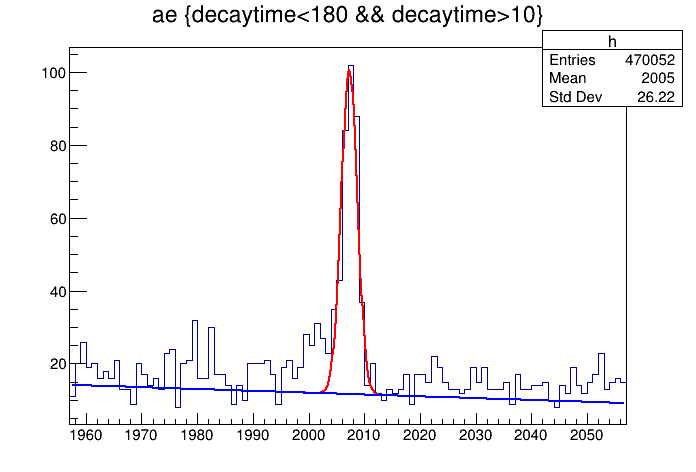

0 peak=2007.32(0.110422) height=88.956 sigma=1.44275 contribution=308.045
chi2/ndf=3.21499 count=319.1 delta_count=21.422


In [26]:
e = vector<double> {2007};
k = -0.05; b = 112;                      //线性本底参数
fit_left = e[0]-10; fit_right = e[0]+10;       //联合拟合范围
area_left = e[0]-3; area_right = e[0]+2;     //峰面积计算范围
area();
h->GetXaxis()->SetRangeUser(e[0]-50,e[0]+50); //设置显示区间
c1->Draw();

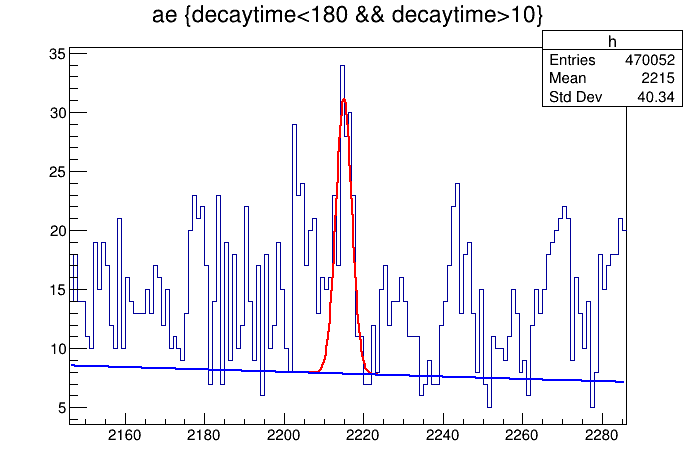

0 peak=2215.11(0.288728) height=23.2761 sigma=2 contribution=109.501
chi2/ndf=2.42732 count=113.485 delta_count=15.9535


In [27]:
e = vector<double> {2216};
k = -0.010; b = 30;                      //线性本底参数
fit_left = e[0]-10; fit_right = e[0]+10;       //联合拟合范围
area_left = e[0]-4; area_right = e[0]+4;     //峰面积计算范围
area();
h->GetXaxis()->SetRangeUser(e[0]-70,e[0]+70); //设置显示区间
c1->Draw();

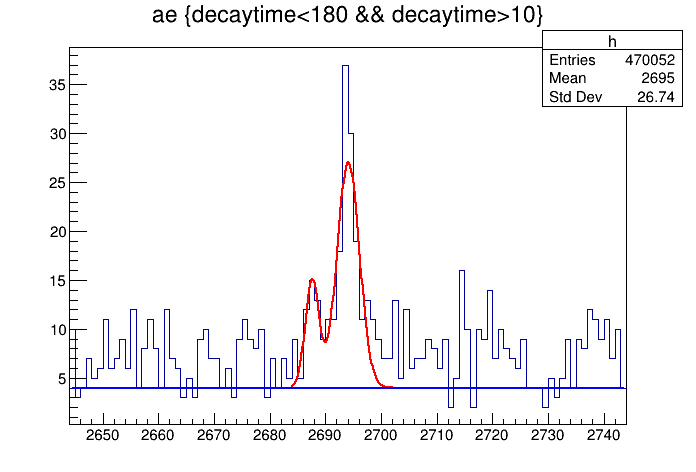

0 peak=2694.14(0.252196) height=23.0411 sigma=2 contribution=99.9599
1 peak=2687.68(0.33579) height=10.9377 sigma=1.248 contribution=0.132443
chi2/ndf=1.72875 count=101.868 delta_count=12.2529


In [28]:
e = vector<double> {2694,2687};
k = -0; b = 4;                      //线性本底参数
fit_left = e[0]-10; fit_right = e[0]+10;       //联合拟合范围
area_left = e[0]-3; area_right = e[0]+2;     //峰面积计算范围
area();
h->GetXaxis()->SetRangeUser(e[0]-50,e[0]+50); //设置显示区间
c1->Draw();